Comparing merge-tests on Salish and Japser. A week long run to see how the differences evolve. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run (3.4)
r1 = 'initial';
runname1 = '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/' + r1 
print runname1

#second run (3.6)
r2 = 'three-six'
runname2 = '/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/'
print runname2

runs = {r1: runname1, r2: runname2}


/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/initial
/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/


In [4]:
fUs={}; fVs={}; fTs={}
for key, path in runs.iteritems():
    fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_U.nc','r');
    fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_V.nc','r');
    fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_T.nc','r');

Show info about the files

In [5]:
for key in runs:
    print key
    nc_tools.show_dataset_attrs(fUs[key])

initial
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 28/05/2015 14:51:46 -0700
file_name: SalishSea_1h_20121214_20121215_grid_U.nc
history: Thu May 28 14:54:57 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121215_grid_U.nc SalishSea_1h_20121214_20121215_grid_U.nc
NCO: 4.4.2
three-six
file format: NETCDF4
name: SalishSea_1h_20121214_20121215
description: ocean U grid variables
conventions: CF-1.1
production: An IPSL model
timeStamp: 2015-Jul-01 13:43:49 PDT


In [6]:
for key in runs:
    print key
    nc_tools.show_variable_attrs(fUs[key])

initial
<type 'netCDF4.Variable'>
float32 depthu(depthu)
    axis: Z
    standard_name: model_level_number
    units: m
    positive: down
    valid_min: 0.5
    valid_max: 441.466
    title: depthu
    long_name: Vertical U levels
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    units: degrees_north
    valid_min: 46.8606
    valid_max: 51.1056
    long_name: Latitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    units: degrees_east
    valid_min: -126.397
    valid_max: -121.316
    long_name: Longitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4.Variable'>
float64 time_counter(t

Different sizes because initial is 48 hours. 

In [7]:

#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig['initial'] = datetime.datetime.strptime(
                    tim_count['initial'].time_origin.title(), ' %Y-%b-%d %H:%M:%S')
t_orig['three-six'] = datetime.datetime.strptime(
                tim_count['three-six'].time_origin.title(), '%Y-%m-%d %H:%M:%S')
t_cent = fTs['three-six'].variables['time_centered'][:]

Check what time_centered is.. Is it the same as time_counter?

In [8]:
t_cent == tim_count['three-six'][:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)

#Comparison plots

Quick look at surface fields near the start adn end of first day

In [9]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0


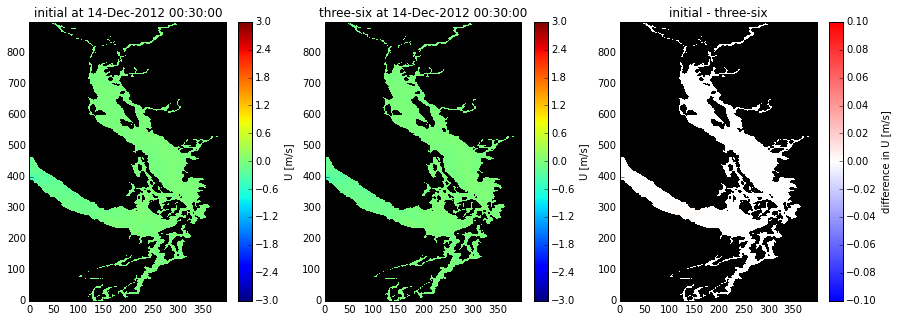

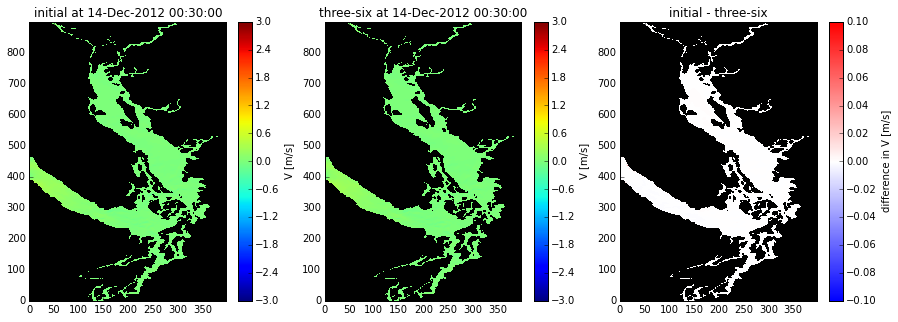

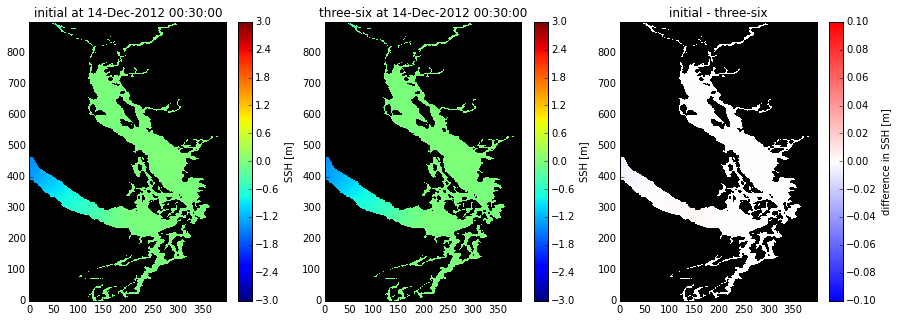

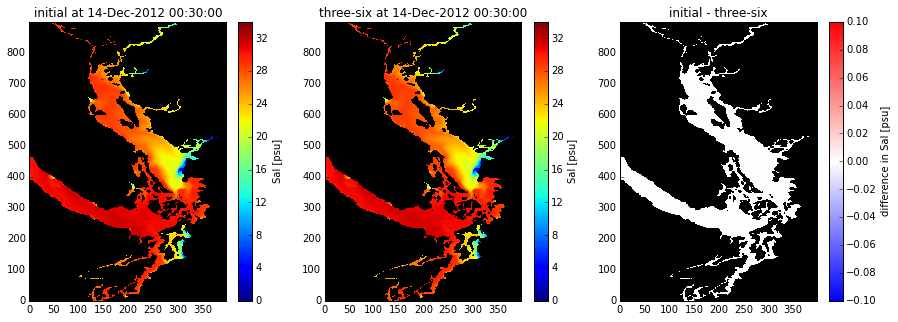

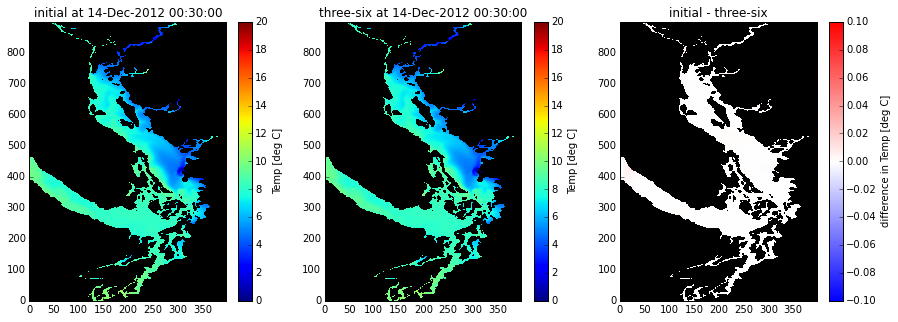

In [10]:
t=0
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=20)

Minor differences in the U/V fields at the SJdF open boundary.

Time = 23, depth level = 0


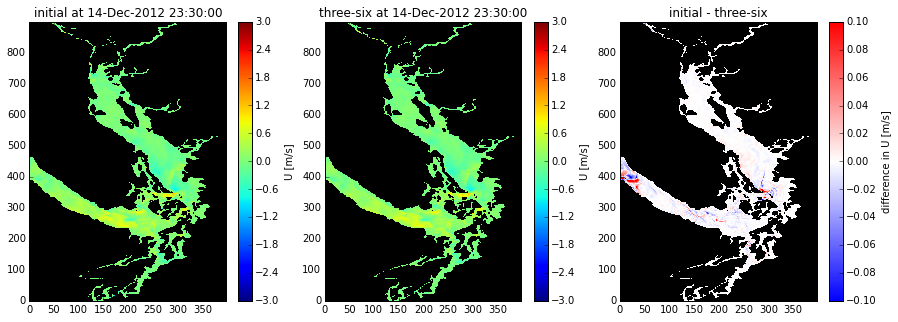

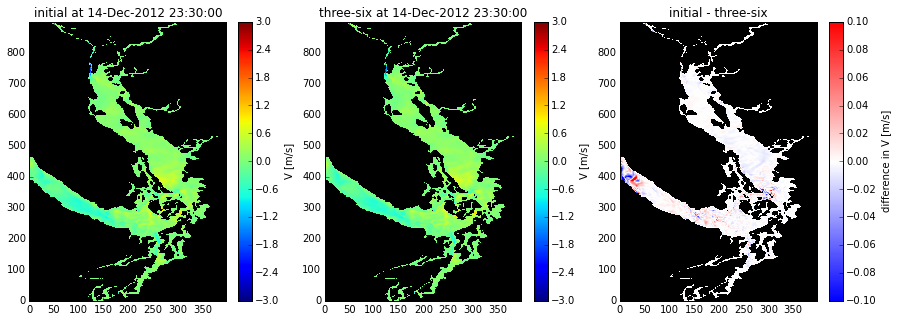

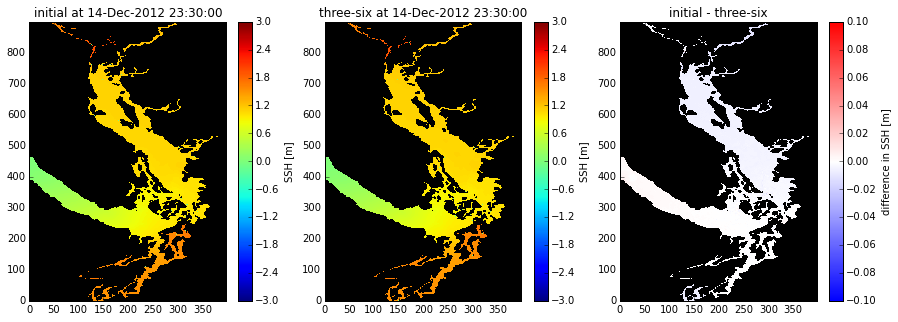

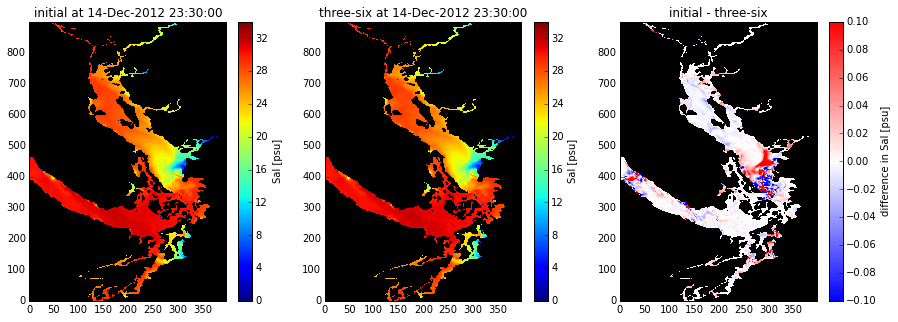

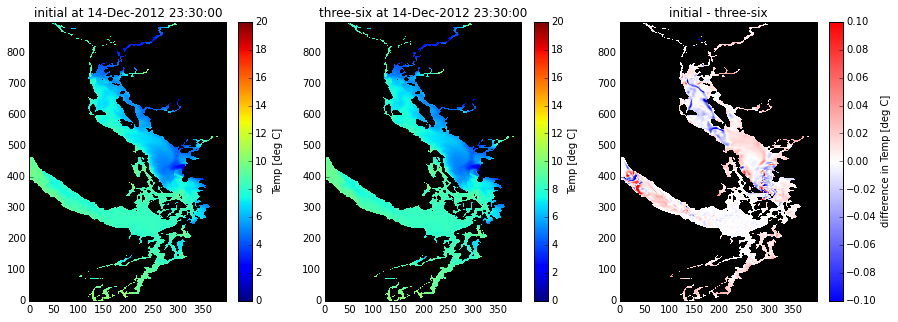

In [11]:
t=23
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=20)

* Differences in U/V at SJdF are larger. 
* The SSH is pretty much the same between the two.
* Differences in temp/salinity in plume and in SJdF 

#Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [12]:
def summarize_differences(var,var_name,imin=0,imax=396,jmin=0,jmax=896):
    diff = var[r1][0:24,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print var_name
    print 'min diff: {0:.3}, index {1}'.format(diff.min(),inds_min)
    print 'max diff: {0:.3}, index {1}'.format(diff.max(),inds_max)
    print 'mean diff {0:.3}'.format(diff.mean())

In [13]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key],key)

V [m/s]
min diff: -0.818, index (5, 0, 433, 2)
max diff: 0.705, index (20, 0, 400, 1)
mean diff -3.37e-06
Temp [deg C]
min diff: -0.804, index (10, 0, 356, 299)
max diff: 1.43, index (20, 3, 419, 312)
mean diff 7.59e-05
SSH [m]
min diff: -2.22, index (21, 896, 41)
max diff: 2.68, index (3, 896, 41)
mean diff -0.000916
U [m/s]
min diff: -1.08, index (4, 1, 430, 1)
max diff: 0.849, index (19, 3, 400, 1)
mean diff -4.28e-06
Sal [psu]
min diff: -2.27, index (10, 0, 356, 299)
max diff: 4.93, index (20, 3, 419, 312)
mean diff 2.46e-05


* Mean diff is perhaps unfair because the fields aren't masked. So there are a whole lot of zeros
* U/V have largest differences near the beginning of simulatio, and JdF open boundary
* Large differences in ssh are probaly because of how the open boundary is treated. 3.4 has an extra layer of zeros at each boundary on the T grid. Perhpas this can explain the U/V differences too?
* Largest temp and salinity difference looks to be just after Boundary Pass at the surface.

Exclude layer surrounding the open boundaries

In [14]:
imin=2; imax=396
jmin=2; jmax=895
for key in variables:
    summarize_differences(variables[key],key,imin,imax,jmin,jmax)

V [m/s]
min diff: -0.818, index (5, 0, 431, 0)
max diff: 0.52, index (21, 0, 398, 0)
mean diff -2.6e-06
Temp [deg C]
min diff: -0.804, index (10, 0, 354, 297)
max diff: 1.43, index (20, 3, 417, 310)
mean diff 7.65e-05
SSH [m]
min diff: -0.104, index (9, 767, 119)
max diff: 0.0562, index (16, 771, 118)
mean diff -0.000927
U [m/s]
min diff: -0.467, index (20, 26, 405, 0)
max diff: 0.673, index (4, 0, 425, 0)
mean diff -4.12e-06
Sal [psu]
min diff: -2.27, index (10, 0, 354, 297)
max diff: 4.93, index (20, 3, 417, 310)
mean diff 2.48e-05


#Bounday conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [15]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

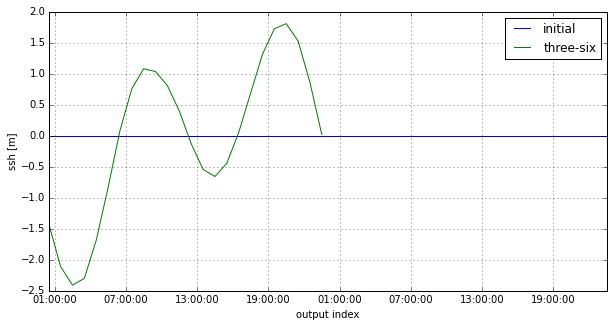

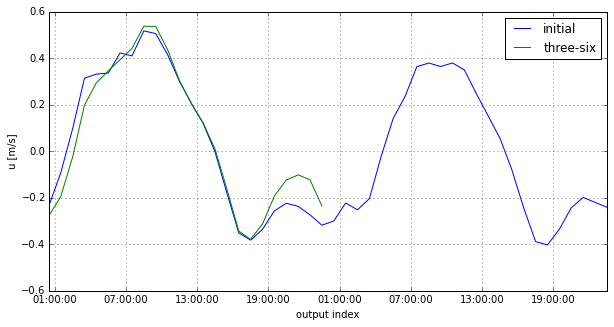

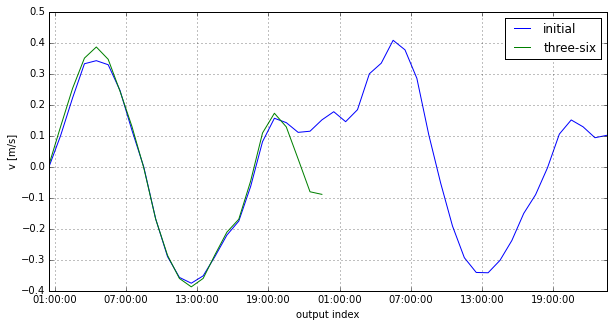

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Why is second index zero in initial but not three-six.

Next to boundary

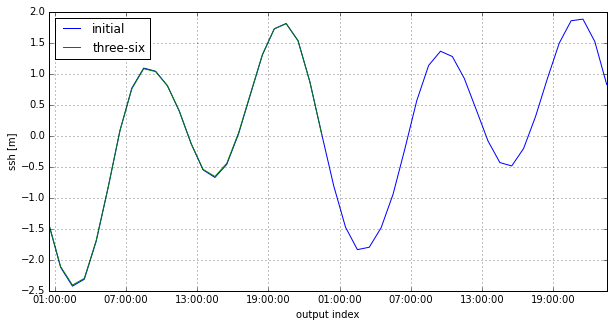

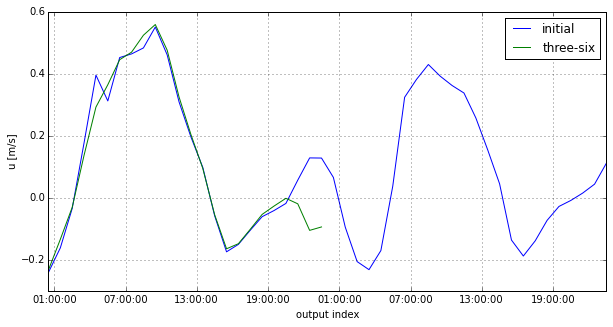

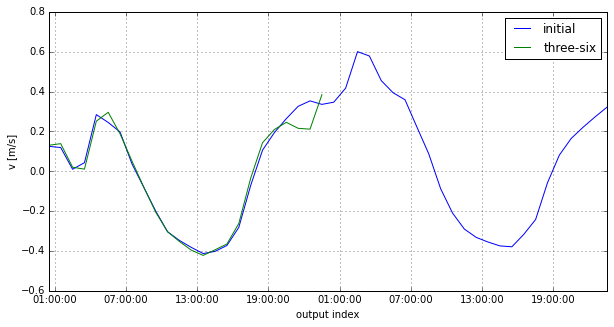

In [17]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

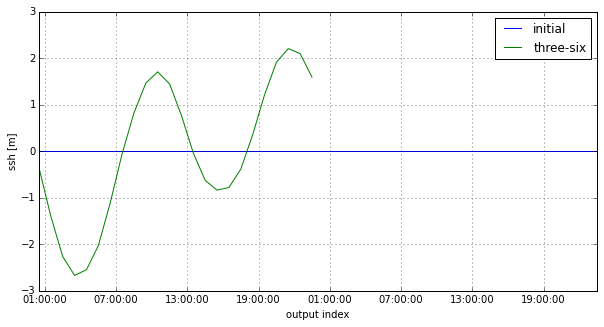

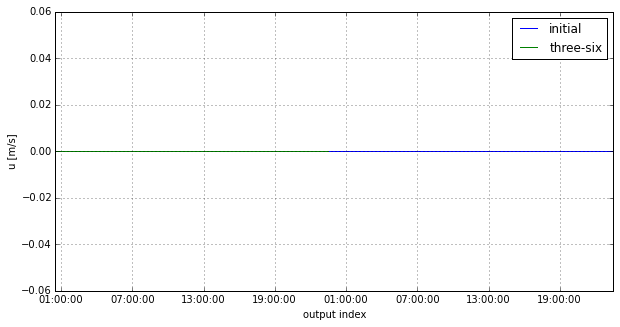

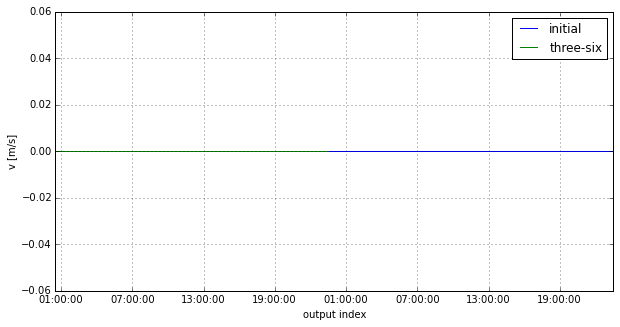

In [18]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Same here. At the north, initial has two points on the T grid that are zero...

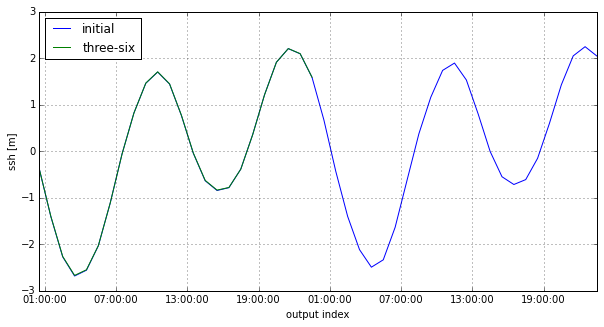

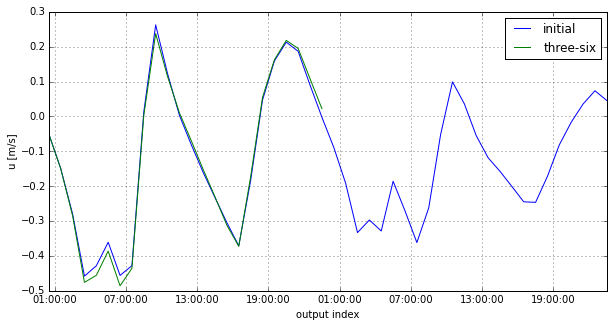

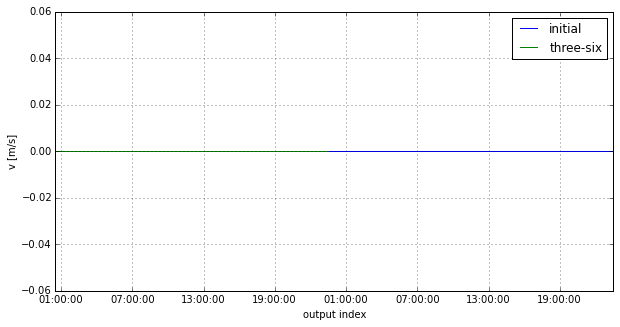

In [19]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Phases align!

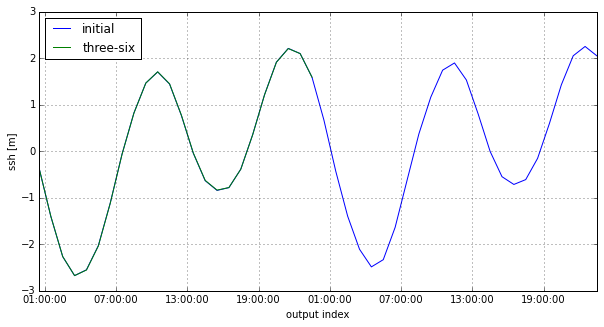

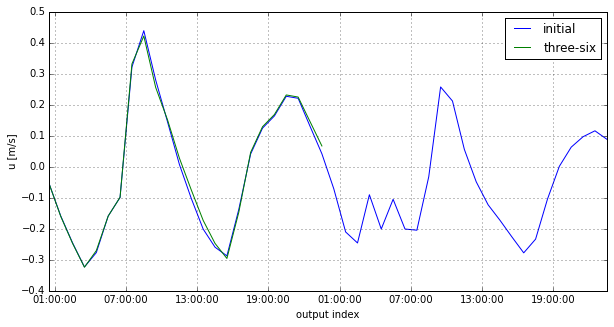

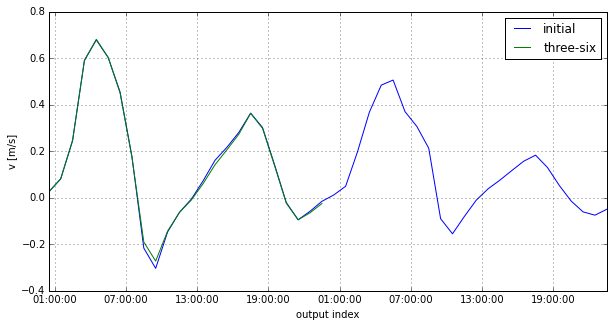

In [20]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at SJdF boundary

Compare fields over depth and along the JdF boundary

In [21]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


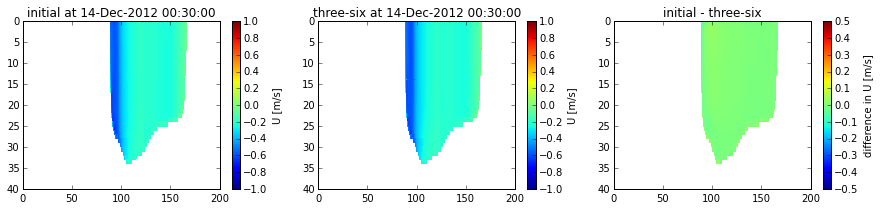

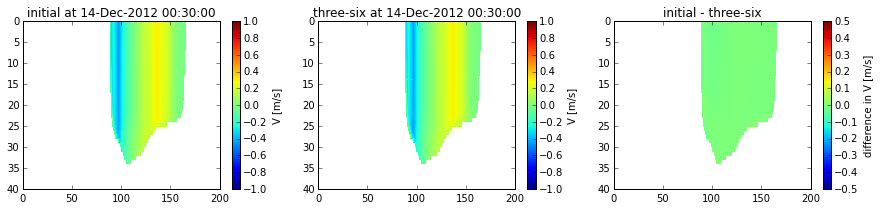

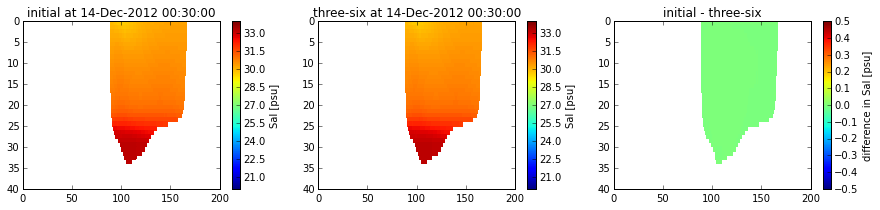

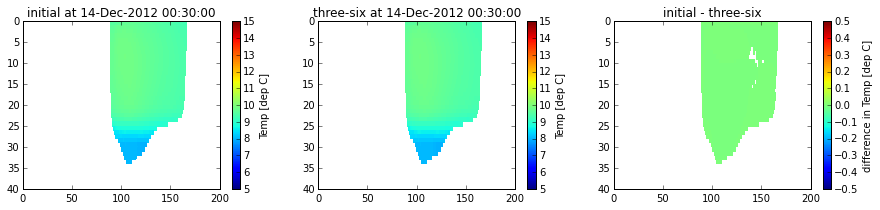

In [22]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Max difference time

Mouth of JdF at t = 5


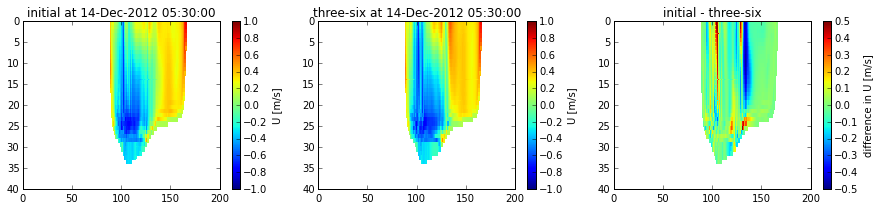

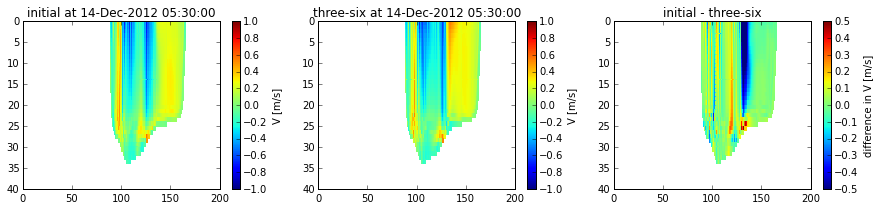

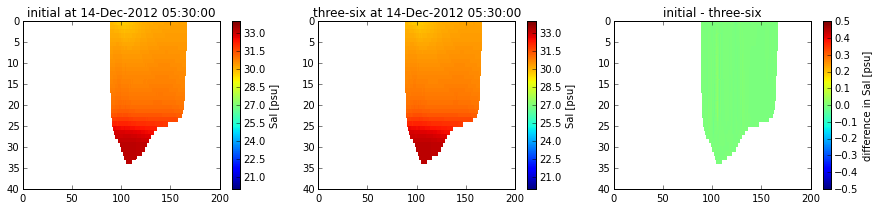

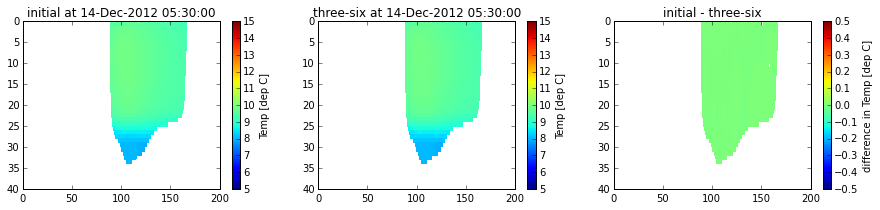

In [23]:
t=5
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Last time

Mouth of JdF at t = 23


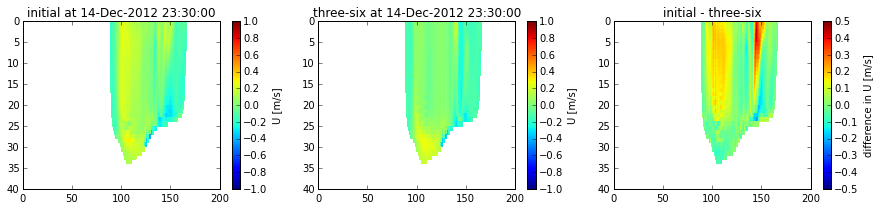

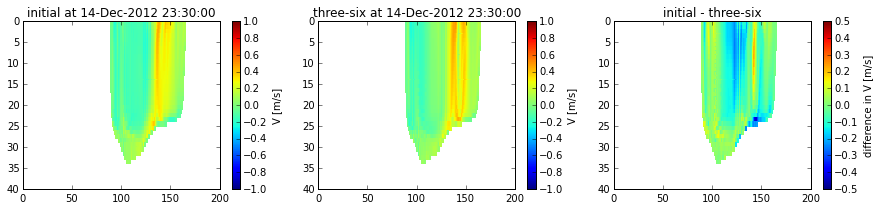

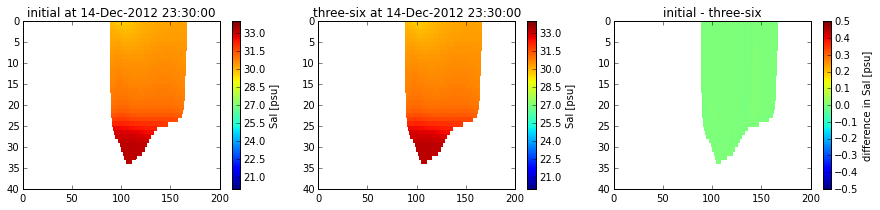

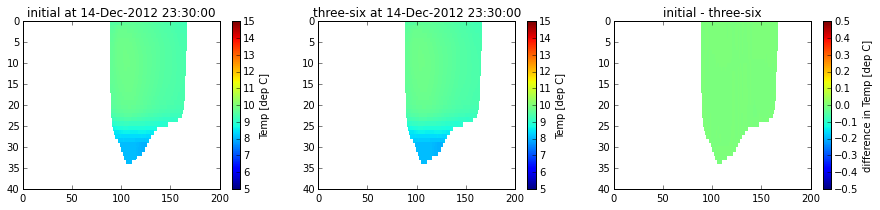

In [24]:
t=23
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)